# Boston Celtics win percentages over the years


Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Boston, Massachusetts, United States** and **sports or athletics**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **sports or athletics**?  For this category we are interested in sporting events or athletics broadly, please feel free to creatively interpret the category when building your research question!

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.

In [16]:
import urllib.request as request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
url = "https://en.wikipedia.org/wiki/List_of_Boston_Celtics_seasons"

page = request.urlopen(url)
soup = BeautifulSoup(page, "lxml")

#print(soup.prettify()) # this will help us read the source code

table = soup.find_all("table")[1].findAll('tr')[1:]

szn = []
wpt = []
champ = []

for row in table:
    szn.append(row.find('a').find(text=True))
    cells = row.findAll('td')
    if len(cells) == 12:
        wpt.append(cells[7].find(text=True).replace('\n','').replace('.','0.'))
    else:
        wpt.append(cells[6].find(text=True).replace('\n','').replace('.','0.'))
        champ.append(cells)

df = pd.DataFrame(szn, columns=['Season'])
df['Reg. Szn Win%'] = wpt
df['Reg. Szn Win%'] = df['Reg. Szn Win%'].astype(float)

In [18]:
url = "https://basketball.realgm.com/nba/teams/Boston-Celtics/2/Playoff-History"

page = request.urlopen(url)
soup = BeautifulSoup(page, "lxml")
table = soup.find_all("table")[0].findAll('tr')[2:]

szn = []
First = []
Second = []
Third = []
Fourth = []

for row in table:
    cells = row.findAll('td')
    if len(cells) > 0:
#        szn.append(cells[0].find(text=True))
        First.append(cells[1].find(text=True))
        Second.append(cells[4].find(text=True))
        Third.append(cells[7].find(text=True))
        Fourth.append(cells[10].find(text=True))

#post_szn = pd.DataFrame(szn, columns=['Season'])
post_szn = pd.DataFrame(First, columns=['First Round'])
#post_szn['First Round'] = First
post_szn['Conf. Semis'] = Second
post_szn['Conf. Finals'] = Third
post_szn['NBA Finals'] = Fourth
post_szn = post_szn.iloc[::-1].reset_index(drop=True)


post_szn['wins'] = [0]*post_szn.shape[0]
post_szn['losses'] = [0]*post_szn.shape[0]

for col in post_szn.loc[:,'First Round':'NBA Finals']:
    post_szn['wins'] = post_szn['wins'] + post_szn[col].str.split('-', expand=True).replace('',0).astype(int)[0]
    post_szn['losses'] = post_szn['losses'] + post_szn[col].str.split('-', expand=True).replace('',0).astype(int)[1]

df["Post Szn Win%"] = (post_szn['wins'] / post_szn.loc[:,'wins':'losses'].sum(axis=1).replace(0, np.nan)).round(3)

In [19]:
window_size = 3 # this will give us a 3-year moving average
df['Reg. Szn Win% moving avg.'] = df['Reg. Szn Win%'].rolling(window_size).mean().round(3)
df['Post Szn Win% moving avg.'] = df['Post Szn Win%'].rolling(window_size).mean().round(3)
df['Year'] = df['Season'].apply(lambda x: int(x[:4])+1)
df = df.set_index('Year')
df.drop('Season', axis=1, inplace=True)

df = df.iloc[window_size-1:]

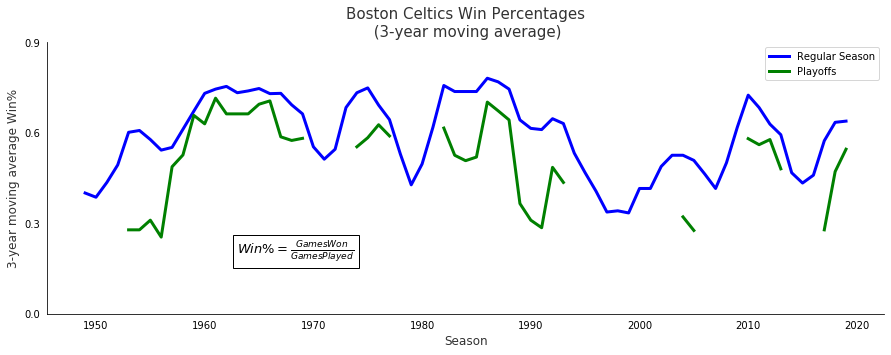

In [71]:
plt.figure(figsize=(15,5))
plt.plot(df.iloc[:,2], '-b', df.iloc[:,3], '-g', linewidth=3)

ax = plt.gca()

plt.xlabel('Season', alpha=0.8, fontsize=12)
plt.ylabel('3-year moving average Win%', alpha=0.8, fontsize=12)
plt.title('Boston Celtics Win Percentages\n (3-year moving average)', alpha=0.8, fontsize=15)

ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True)

ax.set_yticks([0, 0.3, 0.6, 0.9])
#ax.set_yticklabels(labels)
ax.tick_params(axis='x', which = 'minor', length= 0, labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(1963, 0.2, '$Win\%=\\frac{Games Won}{Games Played}$', color='black', fontsize=13, bbox=dict(facecolor='white', edgecolor='black'))

plt.legend(['Regular Season', 'Playoffs']);